Accuracy: 0.9368375125118702

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.62      0.74      5646
           1       0.94      0.99      0.96     33317

    accuracy                           0.94     38963
   macro avg       0.93      0.81      0.85     38963
weighted avg       0.94      0.94      0.93     38963



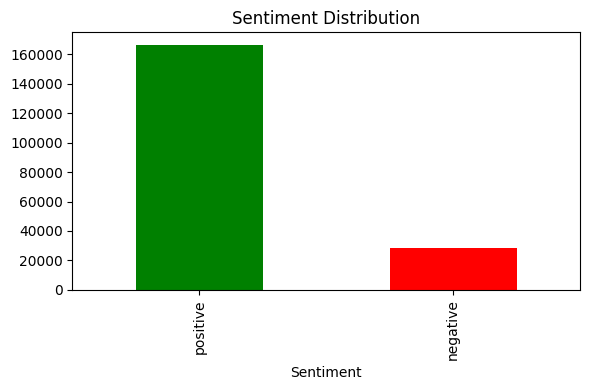

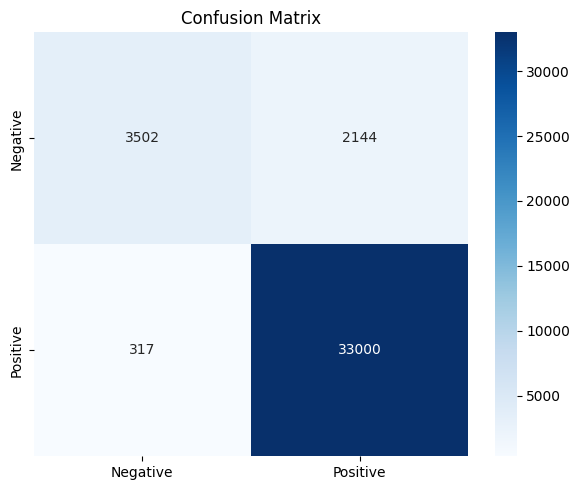

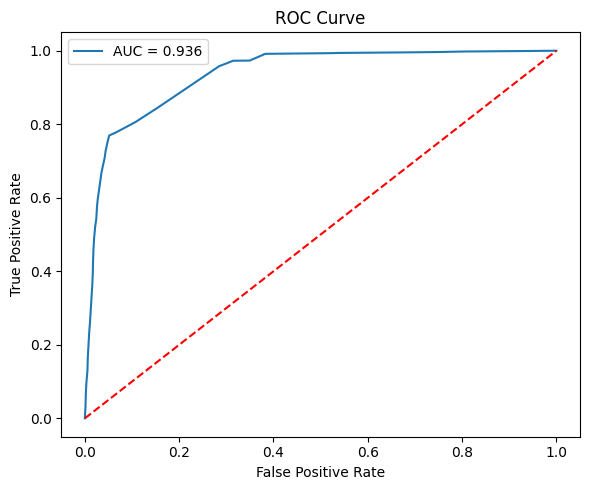

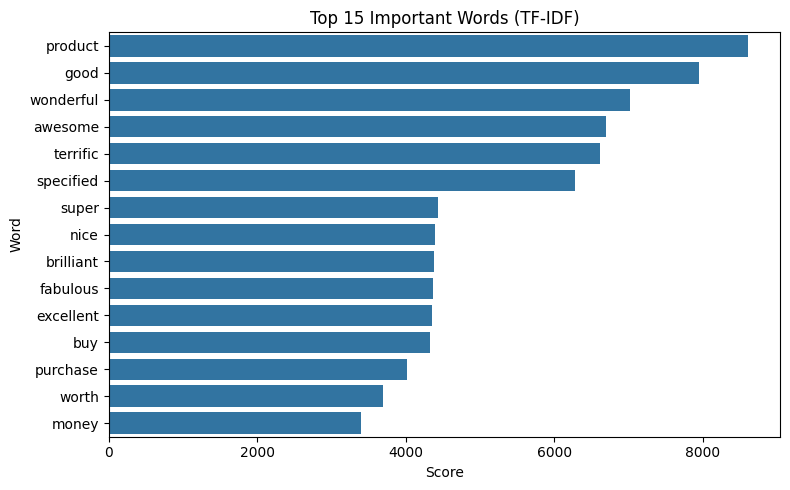

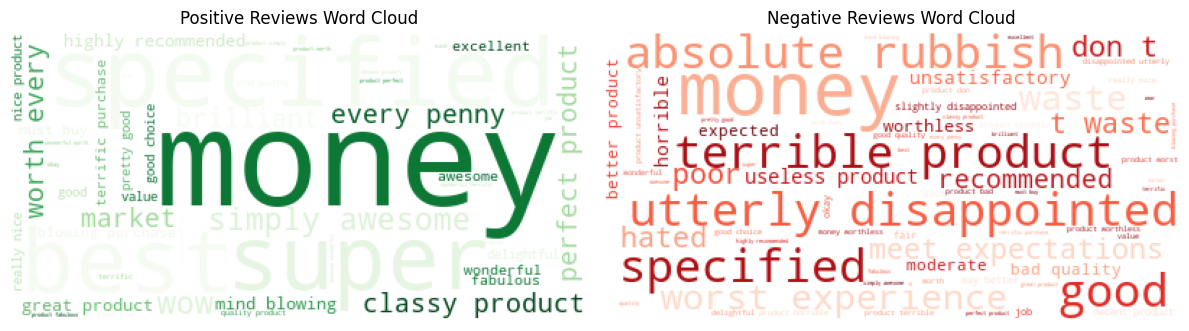

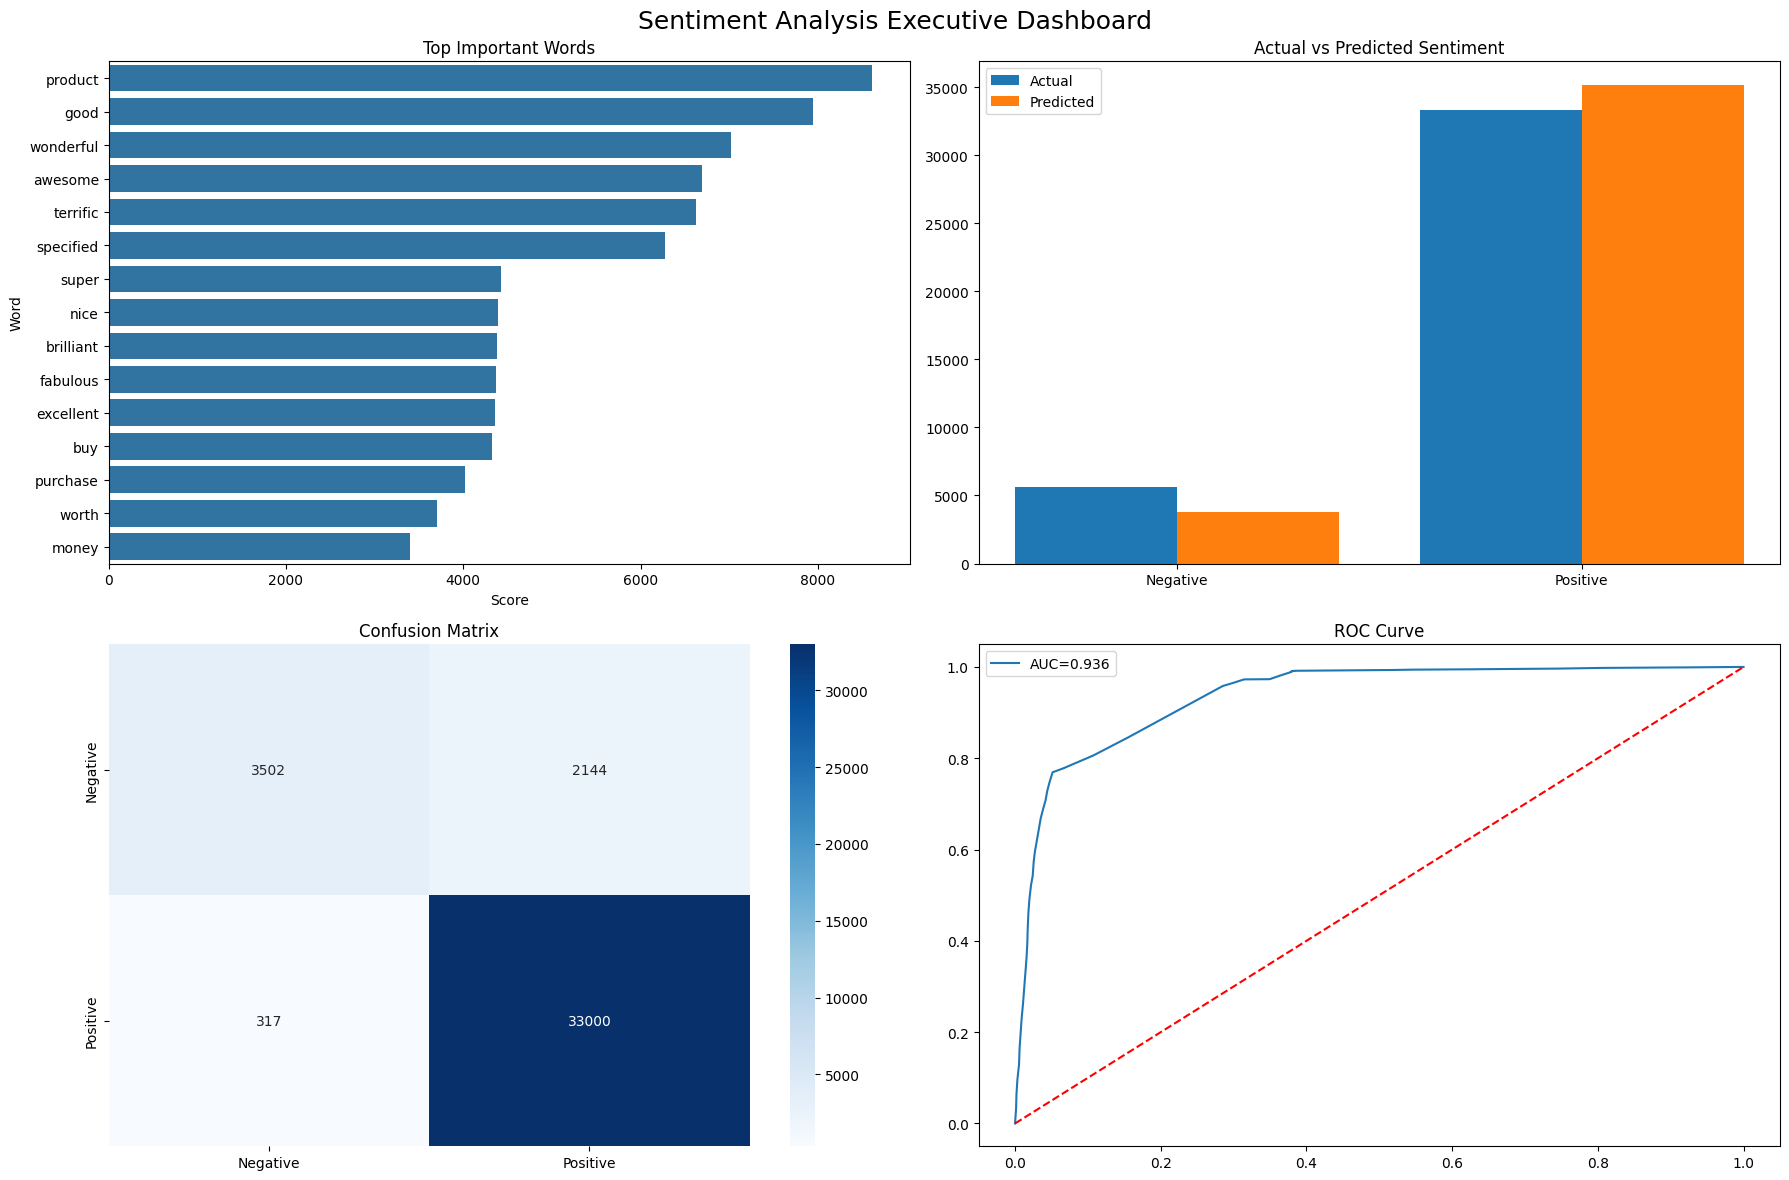


COMPLETE SYSTEM EXECUTED SUCCESSFULLY


In [1]:
# ============================================================
# ENTERPRISE SENTIMENT ANALYSIS SYSTEM
# TF-IDF + Naive Bayes
# ============================================================

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.gridspec as gridspec
import joblib

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score


# 1. Setup Results Folder

results_dir = "Results"
os.makedirs(results_dir, exist_ok=True)

def save_plot(name):
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, name), dpi=300)
    plt.show()


# 2. Load & Clean Dataset

df = pd.read_csv("Dataset-SA.csv")

df = df[df["Sentiment"].isin(["positive", "negative"])]
df["label"] = df["Sentiment"].map({"positive": 1, "negative": 0})

df["Review"] = df["Review"].fillna("").astype(str)
df["Review"] = df["Review"].str.lower()
df["Review"] = df["Review"].str.replace("[^a-zA-Z]", " ", regex=True)

X = df["Review"]
y = df["label"]


# 3. Train Test Split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# 4. TF-IDF Vectorization

vectorizer = TfidfVectorizer(stop_words="english", max_features=5000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


# 5. Train Naive Bayes Model

model = MultinomialNB()
model.fit(X_train_tfidf, y_train)


# 6. Model Evaluation

y_pred = model.predict(X_test_tfidf)
y_prob = model.predict_proba(X_test_tfidf)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)


# 7. Sentiment Distribution

plt.figure(figsize=(6,4))
df["Sentiment"].value_counts().plot(kind="bar", color=["green","red"])
plt.title("Sentiment Distribution")
save_plot("1_Sentiment_Distribution.png")

# 8. Confusion Matrix

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative","Positive"],
            yticklabels=["Negative","Positive"])
plt.title("Confusion Matrix")
save_plot("2_Confusion_Matrix.png")

# 9. ROC Curve

fpr, tpr, _ = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1],[0,1],'r--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
save_plot("3_ROC_Curve.png")

# 10. Top Important Words

tfidf_scores = np.asarray(X_train_tfidf.sum(axis=0)).flatten()
feature_names = vectorizer.get_feature_names_out()

top_words_df = pd.DataFrame({
    "Word": feature_names,
    "Score": tfidf_scores
}).sort_values(by="Score", ascending=False).head(15)

plt.figure(figsize=(8,5))
sns.barplot(x="Score", y="Word", data=top_words_df)
plt.title("Top 15 Important Words (TF-IDF)")
save_plot("4_Top_Words.png")


# 11. Word Clouds

positive_text = " ".join(df[df["label"]==1]["Review"].sample(20000, random_state=42))
negative_text = " ".join(df[df["label"]==0]["Review"].sample(20000, random_state=42))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.imshow(WordCloud(background_color="white", colormap="Greens").generate(positive_text))
plt.axis("off")
plt.title("Positive Reviews Word Cloud")

plt.subplot(1,2,2)
plt.imshow(WordCloud(background_color="white", colormap="Reds").generate(negative_text))
plt.axis("off")
plt.title("Negative Reviews Word Cloud")

save_plot("5_WordClouds.png")


# 12. Executive Dashboard

summary_df = pd.DataFrame({"Actual": y_test, "Predicted": y_pred})
actual_counts = summary_df["Actual"].value_counts().sort_index()
pred_counts = summary_df["Predicted"].value_counts().sort_index()

labels = ["Negative","Positive"]
x = np.arange(len(labels))

plt.figure(figsize=(18,12))
gs = gridspec.GridSpec(2,2)

# Top Words
ax0 = plt.subplot(gs[0,0])
sns.barplot(x="Score", y="Word", data=top_words_df, ax=ax0)
ax0.set_title("Top Important Words")

# Actual vs Predicted
ax1 = plt.subplot(gs[0,1])
ax1.bar(x-0.2, actual_counts, 0.4, label="Actual")
ax1.bar(x+0.2, pred_counts, 0.4, label="Predicted")
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.set_title("Actual vs Predicted Sentiment")
ax1.legend()

# Confusion Matrix
ax2 = plt.subplot(gs[1,0])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels, ax=ax2)
ax2.set_title("Confusion Matrix")

# ROC Curve
ax3 = plt.subplot(gs[1,1])
ax3.plot(fpr, tpr, label=f"AUC={auc:.3f}")
ax3.plot([0,1],[0,1],'r--')
ax3.set_title("ROC Curve")
ax3.legend()

plt.suptitle("Sentiment Analysis Executive Dashboard", fontsize=18)
save_plot("6_Full_Dashboard.png")


# 13. Save Model

joblib.dump(model, "sentiment_model.joblib")
joblib.dump(vectorizer, "tfidf_vectorizer.joblib")

print("\nCOMPLETE SYSTEM EXECUTED SUCCESSFULLY")

